# Astrometry Response functions

In [13]:
import numpy as np
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools
#font = {'family' : 'Latin Modern Roman',
#        'weight' : 'bold',
#        'size'   : 16}
#matplotlib.rc('font',**font)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


## Maps

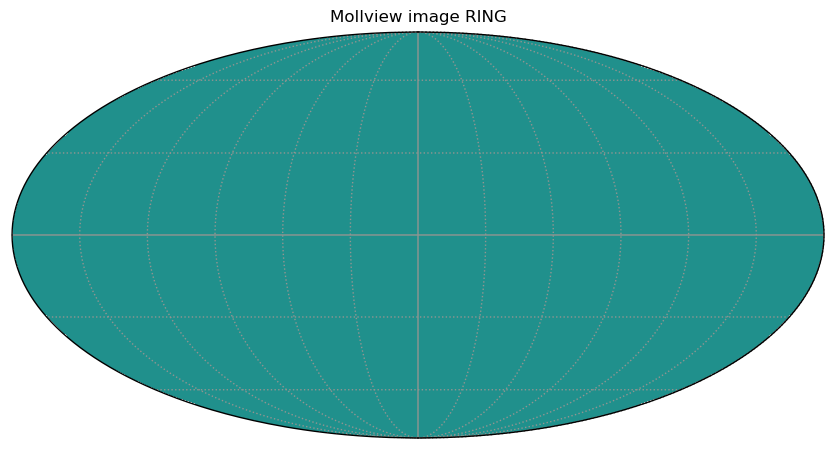

In [14]:
NSIDE = 32 # Resolution of the map (generally a power of 2)
NPIX = hp.nside2npix(NSIDE) # Number of pixels NPIX of the map

#m = np.arange(NPIX) 
m = np.zeros(NPIX) # Comment if a One-color map is preferred.
hp.mollview(m, title="Mollview image RING", cbar=False)
hp.graticule(color='#929591')

We use Mollview from healpy to plot a Map with an array given in Mollweide projection. When using Mollview, the standard coordinates are **spherical** with the co-latitude $\theta \in [0,\pi]$ (North pole to South pole),  and the longitude $\phi \in [0, 2\pi]$ eastward, for the projection, $\phi = 0$ is at the center and increases eastward toward the left of the map.


## Ploting random stars in the Sky

In [15]:
# Set random star positions in spherical coordinates
np.random.seed(9)
num_stars = 60
npair = num_stars*(num_stars-1)/2
theta = np.random.uniform(0, np.pi,num_stars)  # colatitude E[0, pi]
phi = np.random.uniform(0, 2*np.pi, num_stars) # longitude [0, 2pi]

In [16]:
# Going from ecliptic coordinates to spherical ones.
# Velocity with respect to the cosmic frame (in galactic coordinates(l, b) = (264◦, 48◦)):

v_theta = (np.pi/2)-np.radians(-7.145) # (pi/2 - Declination) E[0,pi]
v_phi = np.radians(167.78) # Right Ascension E[0,2pi]

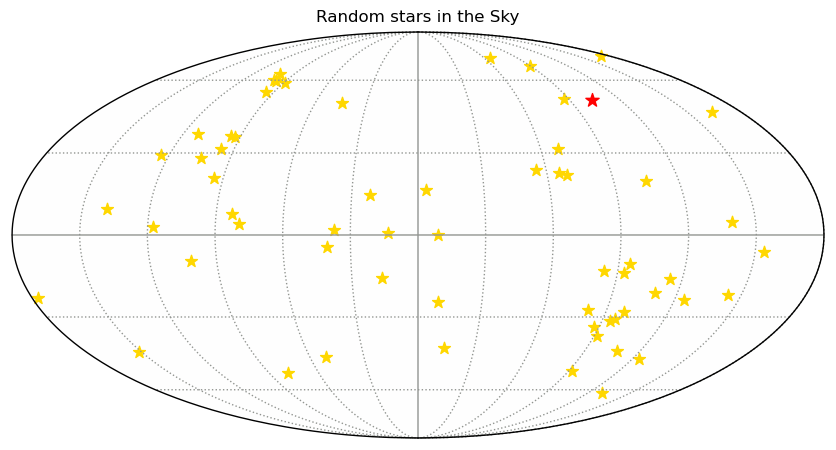

In [17]:
#hp.mollview(m, title="Directions of random star positions in the Sky", cmap='RdGy', cbar=False)
hp.mollview(m, title="Random stars in the Sky", cmap='RdGy', cbar=False, coord=['E','G'], notext=True)
hp.graticule(color='#929591')
hp.projscatter(theta, phi, marker='*',s=80,color='gold', coord=['E','G'])
hp.projscatter(v_theta, v_phi, marker='*',s=100,color='r', coord=['E','G'])      # v
#hp.projscatter(test_theta, test_phi, marker='*',s=100,color='b')#, coord=['E'])      # v

## Changing the color of the map according to a function

In [18]:
# unit vector in R3, given two angles, \theta E[0,pi] and \phi E[0,2pi]
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

In [19]:
def GT_analytic_alpha(v,n1,n2):
    y = (1-np.dot(n1,n2))/2
    n1v = np.dot(n1,v)
    n2v = np.dot(n2,v)
    num = -np.pi*(2*y-1)*(n1v-n2v)*(n1v+n2v)*((y-1)*(2*y+1) - 3*y*np.log(y))
    den = 6*n1v*(y-1)**3
    return num/den

def GT_analytic_beta(v,n1,n2):
    y = (1-np.dot(n1,n2))/2
    n1v = np.dot(n1,v)
    n2v = np.dot(n2,v)
    num = np.pi*y*(n1v+n2v)*((y-1)*(2*y+1) - 3*y*np.log(y))
    den = 3*n1v*(y-1)**2
    return num/den

#I_3 = np.eye(3)
def delta_ij(i, j):
    return 1 if i == j else 0

def GTanalytic_Hij_1(v, n1, n2):
    #y = (1-np.dot(n1,n2))/2 # change to zeta if phi is not 0.
    #n1v = np.dot(n1,v)
    #n2v = np.dot(n2,v)
    #alpha = GT_analytic_alpha(v,n1,n2)
    #beta = GT_analytic_beta(v,n1,n2)
    #t1 = I_3 * (alpha*(2*y+1/(1-2*y) - 1) -2*beta*n2v)
    #t2 = np.outer(n1, n1)*( alpha/(2*y-1) + 2*beta*n2v) +alpha*(np.outer(n1, n2)+np.outer(n2, n1))
    #t3 = np.outer(n2, n2)*alpha/(2*y-1) + 2*beta*(2*y-1)*np.outer(n1, v) + 2*beta*np.outer(n2, v)
    return t1+t2+t3 #alpha*coeff_alpha/(2*y-1) + 2*beta*coeff_beta

In [42]:
np.random.seed(4)
nstrs = 60
npair = nstrs*(nstrs-1)/2
phi = np.random.uniform(0,2*np.pi,nstrs)
theta = np.arccos(np.random.uniform(-1,1,nstrs))

nside = 32
npix = hp.nside2npix(nside)

#frame velocity 
vtheta, vphi = hp.pix2ang(nside, np.arange(npix))
vdir = skyvec(vtheta,vphi) #np.column_stack(skyvec(vtheta,vphi))

#for i in range(npix):
#    v= np.column_stack(vdir)[i]

H0 = np.zeros(npix)
print(npix)
print(vdir.shape)
print(vdir)

12288
(3, 12288)
[[ 0.01804073 -0.01804073 -0.01804073 ... -0.01804073 -0.01804073
   0.01804073]
 [ 0.01804073  0.01804073 -0.01804073 ...  0.01804073 -0.01804073
  -0.01804073]
 [ 0.99967448  0.99967448  0.99967448 ... -0.99967448 -0.99967448
  -0.99967448]]


In [24]:
#for k in range(npix):
#    v = np.array(vdir[k])
#for strpair in itertools.combinations(np.arange(nstrs),2):
        #idx_p,idx_q = strpair
        #n1 = skyvec(theta[idx_p],phi[idx_p])
        #n2 = skyvec(theta[idx_q],phi[idx_q])           
        #H0 += GTanalytic_Hij_1(v, n1, n2)
        #H0 = GTanalytic_Hij_1(v, n1, n2)
        #resultsH0+=H0
resultsH0 = []

#for l in range(npix):
    #for m in range(m!=l,nstrs):
for n in range(nstrs):
            #vf = np.array(vdir[l])
            n1 = np.array([0.,0.,1.]) #skyvec(theta[m],phi[m])
            n2 = skyvec(theta[n],phi[n])           
            H0 = GTanalytic_Hij_1(vf, n1, n2)
            resultsH0.append(H0)
            
            len(resultsH0)

In [33]:
#print(resultsH0)
H1=np.array(resultsH0)
H1.shape
H1pix=H1.flatten()
print(H1pix)

[ 0.00178564  0.00162124  0.00165273 ... -0.00181604 -0.00178564
 -0.00162124]


In [46]:
#m = np.arange(len(resultsH0))
H1_pixls=np.zeros(npix)
H1_pixls= H1pix
len(H0)
#hp.mollview(H0,title='uniform distribution')

12288

In [9]:
#for k in range(npix):
#    v = np.array(vdir[k])
for strpair in itertools.combinations(np.arange(nstrs),2):
        idx_p,idx_q = strpair
        I_3= delta_ij(idx_p, idx_q)
        n1 = skyvec(theta[idx_p],phi[idx_p])
        n2 = skyvec(theta[idx_q],phi[idx_q])
        y = (1-np.dot(n1,n2))/2
        #v= np.column_stack(vdir)
        #v = np.array(vdir[k])
        n1v = np.dot(n1,vdir)
        n2v = np.dot(n2,vdir)
        alpha = GT_analytic_alpha(vdir,n1,n2)
        beta = GT_analytic_beta(vdir,n1,n2)
        t1 = I_3 * (alpha*(2*y+1/(1-2*y) - 1) -2*beta*n2v)
        t2 = (np.outer(n1, n1)[idx_p,idx_p])*( alpha/(2*y-1) + 2*beta*n2v) +alpha*((np.outer(n1, n2)[idx_p,idx_q])+ (np.outer(n2, n1)[idx_q,idx_p]))
        t3 = (np.outer(n2, n2)[idx_q,idx_q])*alpha/(2*y-1) #+ 2*beta*(2*y-1)*np.outer(n1[idx_p], vdir) + 2*beta*np.outer(n2[idx_q], vdir)
        GT = GTanalytic_Hij_1(vdir, n1, n2)
        H0 += GT.flatten()
    #H0 = GTanalytic_Hij_1(vdir, n1, n2)
    #resultsH0+=H0

IndexError: index 3 is out of bounds for axis 1 with size 3

In [ ]:
print(resultsH0) 